In [ ]:
#download the dataset (UC Merced Land Use Dataset):
!wget http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip

In [ ]:
#unzip the dataset file (UCMerced_LandUse.zip):
!unzip UCMerced_LandUse.zip

In [65]:
#analyse the dataset:
import os
dataset_dir = "/content/UCMerced_LandUse/Images"
classes = sorted([entry for entry in os.listdir(dataset_dir)])
counts = [len(os.listdir(os.path.join(dataset_dir,entry))) for entry in classes]
print("classes : " , classes)
print("samples : " , counts)

classes :  ['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings', 'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse', 'harbor', 'intersection', 'mediumresidential', 'mobilehomepark', 'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential', 'storagetanks', 'tenniscourt']
samples :  [100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]


In [73]:
#prepare the dataset and dataloader:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data import random_split

#hyper-parameters:
transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor()])
batch_size = 50

dataset = ImageFolder(dataset_dir , transform=transform)
dataset_size = len(dataset)
train_size = int(0.7*dataset_size)
val_size = int(0.1*dataset_size)
test_size = int(dataset_size-train_size-val_size)

#show the sizes of our datasets:
print("dataset sizes : train = {} , val = {} , test = {}".format(train_size,val_size,test_size))

#split the datasets and define the dataloaders:
train_dataset , val_dataset , test_dataset = random_split(dataset , [train_size,val_size,test_size])
train_loader = DataLoader(train_dataset , batch_size=batch_size , shuffle=True)
val_loader = DataLoader(val_dataset , batch_size=batch_size , shuffle=True)
test_loader = DataLoader(test_dataset , batch_size=batch_size , shuffle=True)

#group our dataloaders:
dataloader = {'train':train_loader , 'val':val_loader , 'test':test_loader}

dataset sizes : train = 1470 , val = 210 , test = 420


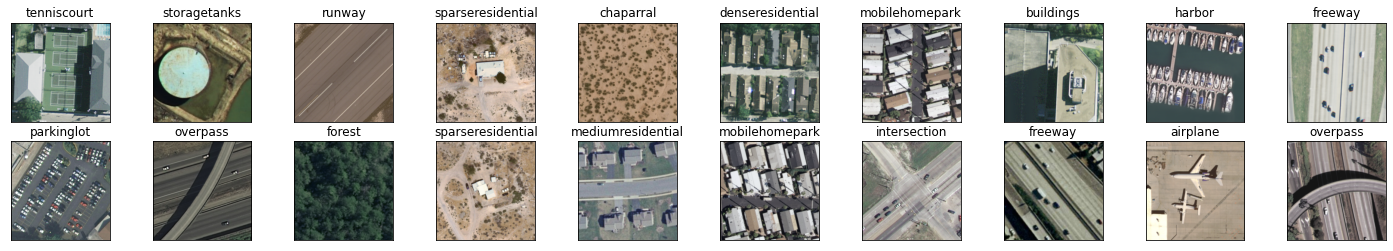

In [74]:
#show some data samples:
import matplotlib.pyplot as plt
import numpy as np

images , labels = iter(dataloader['train']).next()
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in range(20):
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(images[idx].T))
  ax.set_title(str(classes[labels[idx].item()]))
#print(batch[0] , labels[0] , classes[int(labels[0])])

In [67]:
#define out NN model:
#download pre-trained CNN models for feature extraction:
from torchvision import models

vgg16 = models.vgg16(pretrained=True)

# print out the model structure
print(vgg16)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [68]:
# Freeze training for all "features" layers
for param in vgg16.features.parameters():
    param.requires_grad = False

In [71]:
import torch

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [72]:
import torch.nn as nn

n_inputs = vgg16.classifier[6].in_features

# add last linear layer (n_inputs -> 21 land classes)
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, len(classes))

vgg16.classifier[6] = last_layer

# if GPU is available, move the model to GPU
if train_on_gpu:
    vgg16.cuda()

# check to see that your last layer produces the expected number of outputs
print(vgg16.classifier[6].out_features)
#print(vgg16)

21


In [75]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001)

In [81]:
#start trining our model:
# number of epochs to train the model
n_epochs = 10
print_every = 10

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    val_loss = 0.0
    ###################
    # train the model #
    ###################
    # model by default is set to train
    for batch_i, (data, target) in enumerate(dataloader['train']):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = vgg16(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss 
        train_loss += loss.item()
        
        if batch_i % print_every == print_every-1:    # print training loss every specified number of mini-batches
            #validate the model:
            vgg16.eval()
            data , target = iter(dataloader['val']).next()
            if train_on_gpu:
              data, target = data.cuda(), target.cuda()
            output = vgg16(data)
            vgg16.train()
            val_loss = criterion(output,target)
            print('Epoch %d, Batch %d train loss: %.16f val loss: %.16f' %
                  (epoch, batch_i + 1, train_loss / print_every, val_loss))
            train_loss = 0.0

Epoch 1, Batch 10 train loss: 1.7818852305412292 val loss: 1.7626637220382690
Epoch 1, Batch 20 train loss: 1.7295811414718627 val loss: 1.7474379539489746
Epoch 1, Batch 30 train loss: 1.7175844907760620 val loss: 1.5721186399459839
Epoch 2, Batch 10 train loss: 1.6373671412467956 val loss: 1.6168981790542603
Epoch 2, Batch 20 train loss: 1.6248546123504639 val loss: 1.6304293870925903
Epoch 2, Batch 30 train loss: 1.5879864573478699 val loss: 1.5204796791076660
Epoch 3, Batch 10 train loss: 1.5351144433021546 val loss: 1.5361272096633911
Epoch 3, Batch 20 train loss: 1.4957767486572267 val loss: 1.5328896045684814
Epoch 3, Batch 30 train loss: 1.4664833188056945 val loss: 1.3999077081680298
Epoch 4, Batch 10 train loss: 1.4013895988464355 val loss: 1.3293267488479614
Epoch 4, Batch 20 train loss: 1.3910569190979003 val loss: 1.3427035808563232
Epoch 4, Batch 30 train loss: 1.3442225813865663 val loss: 1.2728308439254761
Epoch 5, Batch 10 train loss: 1.3007753372192383 val loss: 1.288

In [84]:
# track test loss 
# over 5 flower classes
test_loss = 0.0
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))

vgg16.eval() # eval mode

# iterate over test data
for data, target in dataloader['test']:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = vgg16(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update  test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(data.size(0)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(len(classes)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.889939

Test Accuracy of agricultural: 95% (23/24)
Test Accuracy of airplane: 90% (19/21)
Test Accuracy of baseballdiamond: 75% (15/20)
Test Accuracy of beach: 100% (21/21)
Test Accuracy of buildings: 47% (11/23)
Test Accuracy of chaparral: 95% (21/22)
Test Accuracy of denseresidential: 29% ( 5/17)
Test Accuracy of forest: 86% (25/29)
Test Accuracy of freeway: 76% (16/21)
Test Accuracy of golfcourse: 87% (14/16)
Test Accuracy of harbor: 100% (21/21)
Test Accuracy of intersection: 75% (12/16)
Test Accuracy of mediumresidential: 66% (12/18)
Test Accuracy of mobilehomepark: 93% (14/15)
Test Accuracy of overpass: 100% (21/21)
Test Accuracy of parkinglot: 100% (21/21)
Test Accuracy of river: 66% (14/21)
Test Accuracy of runway: 100% (17/17)
Test Accuracy of sparseresidential: 80% (17/21)
Test Accuracy of storagetanks: 75% (15/20)
Test Accuracy of tenniscourt: 73% (11/15)

Test Accuracy (Overall): 82% (345/420)


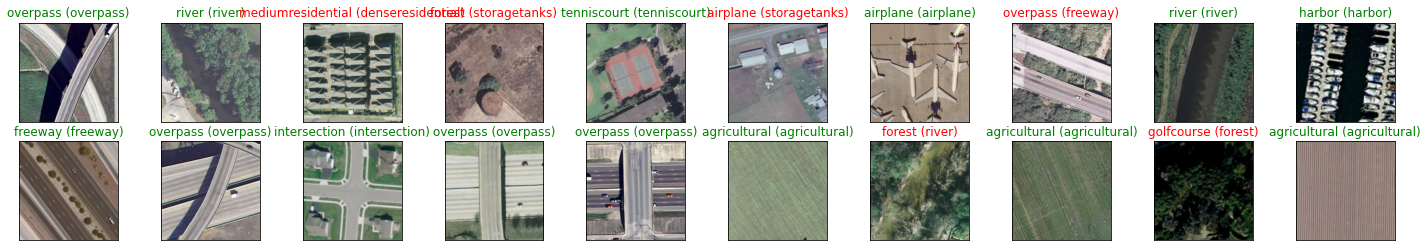

In [90]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = vgg16(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx].cpu(), (1, 2, 0)))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))